# SETUP ENVIRONMENT (Collab GPU / Dependencies)

In [8]:
!nvidia-smi
!pip install --quiet optuna torch torchvision torchaudio scikit-learn matplotlib pandas numpy gdown

import os, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.base import BaseEstimator, RegressorMixin

import torch, torch.nn as nn, torch.optim as optim
import optuna
import warnings
warnings.filterwarnings("ignore")

Wed Oct 15 16:28:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# CONSTANT SEED SETTING

In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device} ({torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'})")

✅ Using device: cuda (Tesla T4)


# DATA LOAD

In [5]:
from google.colab import drive
drive.mount('/content/drive')

file_id = "1a8XaGByqoz9xmpsFylUf7HXXAfOx8Aj2"
url = f"https://drive.google.com/uc?id={file_id}"
output = "EEW_features_2024-10-21.csv"
import gdown
gdown.download(url, output, quiet=False)

df = pd.read_csv(output, skiprows=[1])
df.columns = df.columns.str.strip()

for col in df.columns:
    if col not in ['filename', 'date', 'time']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.fillna(df.median(numeric_only=True))

p_wave_features = ['pkev12', 'pkev23', 'durP', 'tauPd', 'tauPt',
                   'PDd', 'PVd', 'PAd', 'PDt', 'PVt', 'PAt',
                   'ddt_PDd', 'ddt_PVd', 'ddt_PAd', 'ddt_PDt', 'ddt_PVt', 'ddt_PAt']

df = df[(df[p_wave_features] > 0).all(axis=1)]

X = df[p_wave_features]
y_raw = df['PGA']
X = np.log1p(X)
y_log = np.log1p(y_raw)

Mounted at /content/drive


Downloading...
From: https://drive.google.com/uc?id=1a8XaGByqoz9xmpsFylUf7HXXAfOx8Aj2
To: /content/EEW_features_2024-10-21.csv
100%|██████████| 6.82M/6.82M [00:00<00:00, 36.7MB/s]


# STRATIFIED SPLIT
To Preserve Distribution

In [6]:
y_bins = pd.qcut(y_log, q=10, labels=False, duplicates='drop')
sss1 = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
train_idx, temp_idx = next(sss1.split(X, y_bins))
sss2 = StratifiedShuffleSplit(n_splits=1, train_size=0.5, random_state=42)
val_idx, test_idx = next(sss2.split(X.iloc[temp_idx], y_bins.iloc[temp_idx]))
val_idx, test_idx = temp_idx[val_idx], temp_idx[test_idx]

X_train, X_val, X_test = X.iloc[train_idx], X.iloc[val_idx], X.iloc[test_idx]
y_train_log, y_val_log, y_test_log = y_log.iloc[train_idx], y_log.iloc[val_idx], y_log.iloc[test_idx]
y_train_raw, y_val_raw, y_test_raw = y_raw.iloc[train_idx], y_raw.iloc[val_idx], y_raw.iloc[test_idx]

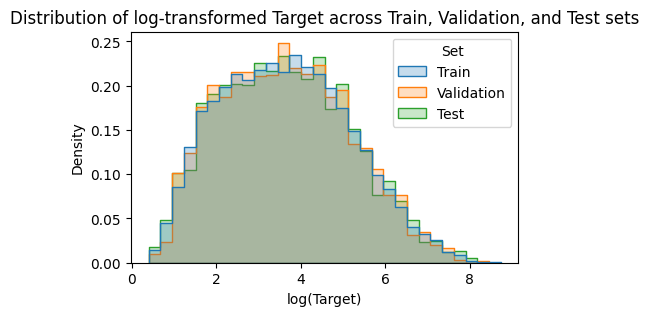

In [16]:
plot_df = pd.DataFrame({
    'Target (Log)': pd.concat([y_train_log, y_val_log, y_test_log], axis=0),
    'Set': ['Train']*len(y_train_log) + ['Validation']*len(y_val_log) + ['Test']*len(y_test_log)
})

plt.figure(figsize=(5,3))
sns.histplot(data=plot_df, x='Target (Log)', hue='Set', element='step', stat='density', common_norm=False, bins=30)
plt.title('Distribution of log-transformed Target across Train, Validation, and Test sets')
plt.xlabel('log(Target)')
plt.ylabel('Density')
plt.show()

# EVALUATION METRICES

In [10]:
def evaluate(model, X, y_log, y_raw):
    preds_log = model.predict(X)
    preds_raw = np.expm1(preds_log)

    metrics_log = {
        'R2': r2_score(y_log, preds_log),
        'MAE': mean_absolute_error(y_log, preds_log),
        'RMSE': np.sqrt(mean_squared_error(y_log, preds_log))
    }

    metrics_raw = {
        'R2': r2_score(y_raw, preds_raw),
        'MAE': mean_absolute_error(y_raw, preds_raw),
        'RMSE': np.sqrt(mean_squared_error(y_raw, preds_raw))
    }

    return metrics_log, metrics_raw

# NEURAL NETWORK

In [11]:

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout):
        super().__init__()
        layers = []
        in_size = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_size, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_size = h
        layers.append(nn.Linear(in_size, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class TorchNN(BaseEstimator, RegressorMixin):
    def __init__(self, input_size, hidden_sizes, lr=0.01, epochs=500, weight_decay=1e-3, dropout=0.2):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.lr = lr
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.dropout = dropout
        self.model = NeuralNetwork(input_size, hidden_sizes, dropout).to(device)

    def fit(self, X, y, X_val=None, y_val=None):
        set_seed(4)
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1,1).to(device)
        if X_val is not None:
            X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
            y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1,1).to(device)
        criterion = nn.HuberLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        best_loss = float('inf')
        best_model = None
        patience, wait = 25, 0

        for epoch in range(self.epochs):
            self.model.train()
            optimizer.zero_grad()
            loss = criterion(self.model(X_tensor), y_tensor)
            loss.backward()
            optimizer.step()

            if X_val is not None:
                self.model.eval()
                with torch.no_grad():
                    val_loss = criterion(self.model(X_val_tensor), y_val_tensor).item()
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_model = deepcopy(self.model.state_dict())
                    wait = 0
                else:
                    wait += 1
                if wait >= patience:
                    break

        if best_model is not None:
            self.model.load_state_dict(best_model)
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            return self.model(X_tensor).cpu().numpy().flatten()

# OPTUNA FOR HYPERPARAMETER TUNING

In [12]:
def objective(trial):
    num_layers = trial.suggest_int('num_layers', 1, 5)
    hidden = [trial.suggest_int(f'n_units_l{i}', 2, 512) for i in range(num_layers)]
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.2, 0.4)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    epochs = trial.suggest_int('epochs', 600, 1200)

    y_bins_cv = pd.qcut(y_train_log, q=10, labels=False, duplicates='drop')
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    mae_scores = []

    for tr_idx, val_idx in skf.split(X_train, y_bins_cv):
        X_tr, X_val_split = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val_split = y_train_log.iloc[tr_idx], y_train_log.iloc[val_idx]

        scaler = RobustScaler()
        imputer = SimpleImputer(strategy='mean')
        selector = SelectKBest(score_func=f_regression, k='all')

        X_tr_prep = selector.fit_transform(imputer.fit_transform(scaler.fit_transform(X_tr)), y_tr)
        X_val_prep = selector.transform(imputer.transform(scaler.transform(X_val_split)))

        model = TorchNN(X_tr_prep.shape[1], hidden, lr=lr, dropout=dropout,
                        weight_decay=weight_decay, epochs=epochs)
        model.fit(X_tr_prep, y_tr, X_val_prep, y_val_split)
        preds = model.predict(X_val_prep)
        mae_scores.append(mean_absolute_error(y_val_split, preds))

    return np.mean(mae_scores)

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50, timeout=1800)



[I 2025-10-15 16:29:09,753] A new study created in memory with name: no-name-f86f1cf2-513b-4aba-9b93-b49aae7a55a8
[I 2025-10-15 16:29:24,779] Trial 0 finished with value: 0.47409955540241455 and parameters: {'num_layers': 2, 'n_units_l0': 487, 'n_units_l1': 376, 'lr': 0.0015751320499779737, 'dropout': 0.23120372808848733, 'weight_decay': 2.9375384576328313e-06, 'epochs': 634}. Best is trial 0 with value: 0.47409955540241455.
[I 2025-10-15 16:29:36,485] Trial 1 finished with value: 0.5616413773674592 and parameters: {'num_layers': 5, 'n_units_l0': 309, 'n_units_l1': 363, 'n_units_l2': 12, 'n_units_l3': 497, 'n_units_l4': 427, 'lr': 0.00026587543983272726, 'dropout': 0.23636499344142015, 'weight_decay': 3.549878832196506e-06, 'epochs': 782}. Best is trial 0 with value: 0.47409955540241455.
[I 2025-10-15 16:29:46,413] Trial 2 finished with value: 0.5083694517336129 and parameters: {'num_layers': 3, 'n_units_l0': 222, 'n_units_l1': 150, 'n_units_l2': 314, 'lr': 0.00019010245319870352, 'dro

# TRAINING IN THE OPTIMAL HYPERPARAMETER SPACE

In [13]:
best_params = study.best_params
hidden_sizes = [best_params[f'n_units_l{i}'] for i in range(best_params['num_layers'])]

scaler = RobustScaler().fit(X_train)
imputer = SimpleImputer(strategy='mean').fit(X_train)
selector = SelectKBest(score_func=f_regression, k='all').fit(X_train, y_train_log)

X_train_sel = selector.transform(imputer.transform(scaler.transform(X_train)))
X_val_sel = selector.transform(imputer.transform(scaler.transform(X_val)))
X_test_sel = selector.transform(imputer.transform(scaler.transform(X_test)))

final_model = TorchNN(
    X_train_sel.shape[1], hidden_sizes,
    lr=best_params['lr'], dropout=best_params['dropout'],
    weight_decay=best_params['weight_decay'], epochs=best_params['epochs']
)
final_model.fit(X_train_sel, y_train_log, X_val_sel, y_val_log)


TorchNN(dropout=0.2835776221997114, epochs=829, hidden_sizes=[428, 442, 220],
        input_size=17, lr=0.0011676487575205433,
        weight_decay=6.370451204388144e-05)

# MODEL EVALUATION

In [14]:
metrics_train_log, metrics_train_raw = evaluate(final_model, X_train_sel, y_train_log, y_train_raw)
metrics_val_log, metrics_val_raw = evaluate(final_model, X_val_sel, y_val_log, y_val_raw)
metrics_test_log, metrics_test_raw = evaluate(final_model, X_test_sel, y_test_log, y_test_raw)

print("Evaluation Metrics (Log Scale):")
print(pd.DataFrame({'Train': metrics_train_log, 'Val': metrics_val_log, 'Test': metrics_test_log}).T)
print("\nEvaluation Metrics (Raw Scale):")
print(pd.DataFrame({'Train': metrics_train_raw, 'Val': metrics_val_raw, 'Test': metrics_test_raw}).T)

Evaluation Metrics (Log Scale):
             R2       MAE      RMSE
Train  0.851408  0.452372  0.588051
Val    0.843178  0.462136  0.597727
Test   0.848967  0.463419  0.598741

Evaluation Metrics (Raw Scale):
             R2        MAE        RMSE
Train  0.762244  47.370988  127.707430
Val    0.797154  45.473552  110.954452
Test   0.741104  51.062750  140.790191


# GRAPHICAL

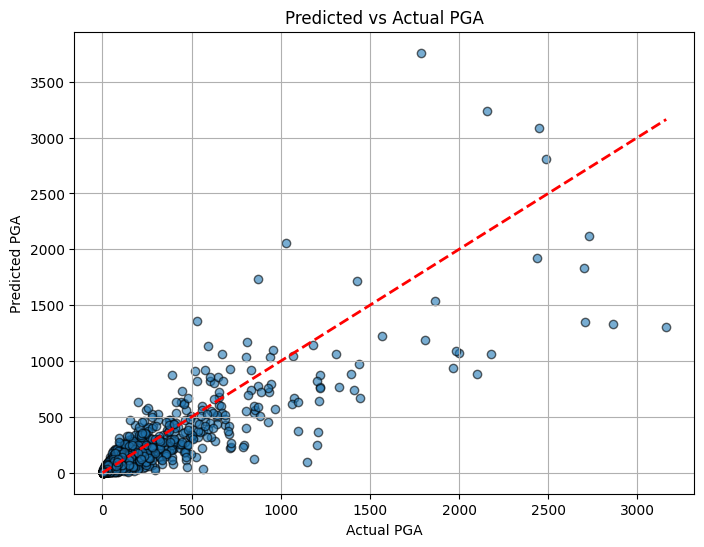

In [15]:
preds_log = final_model.predict(X_test_sel)
preds_raw = np.expm1(preds_log)

plt.figure(figsize=(8,6))
plt.scatter(y_test_raw, preds_raw, alpha=0.6, edgecolor='k')
plt.plot([min(y_test_raw), max(y_test_raw)], [min(y_test_raw), max(y_test_raw)], 'r--', lw=2)
plt.xlabel('Actual PGA')
plt.ylabel('Predicted PGA')
plt.title('Predicted vs Actual PGA')
plt.grid(True)
plt.show()